In [1]:
import os
import sys
import importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import joblib
from xgboost import XGBRegressor
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError


2025-08-30 13:19:10.667796: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756552750.689219 1672762 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756552750.696897 1672762 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1756552750.715297 1672762 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1756552750.715324 1672762 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1756552750.715326 1672762 computation_placer.cc:177] computation placer alr

In [2]:
# add sys.path and dynamic import
def _add_sys_path(path):
    abspath = os.path.abspath(path)
    if abspath not in sys.path:
        sys.path.insert(0, abspath)


In [ ]:
def _load_src(project_root, model_folder, is_linear):
    """Import the correct load_data / preprocess_data / evaluate_model for a family."""
    parent_dir = os.path.dirname(project_root)
    _add_sys_path(parent_dir)  
    project_pkg = os.path.basename(project_root)

    load_data_mod = importlib.import_module(f"{project_pkg}.Common_Code.data_loading")
    eval_mod      = importlib.import_module(f"{project_pkg}.Common_Code.evaluation")

    if is_linear:
        pre_mod = importlib.import_module(f"{project_pkg}.Linear_Regression.preprocessing")
    else:
        pre_mod = importlib.import_module(f"{project_pkg}.{model_folder}.Single_Zone_Tuning.src.preprocessing")

    return load_data_mod.load_data, pre_mod.preprocess_data, eval_mod.evaluate_model


In [4]:
# predictors for each family
def _predict_linear(model_path, X_test):
    model = joblib.load(model_path)
    return model.predict(X_test)

def _predict_gpr(model_path, X_test):
    model = joblib.load(model_path)
    y_mean, _ = model.predict(X_test, return_std=True)
    return y_mean

def _predict_xgb(model_path, X_test):
    model = XGBRegressor()
    model.load_model(model_path)
    return model.predict(X_test)

def _predict_lstm(model_path, X_test_seq, scaler_y):
    model = load_model(model_path, custom_objects={"mse": MeanSquaredError()})
    y_pred = model.predict(X_test_seq, verbose=0).flatten()
    return scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()

def _predict_transformer(model_path, X_dict, scaler_y):
    model = load_model(model_path, custom_objects={"mse": MeanSquaredError()})
    y_pred = model.predict(X_dict, verbose=0).flatten()
    return scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()


In [5]:
# order: [Linear, XGBoost, GPR, LSTM, Transformer]
def build_cfg(root, model_ids, params_by_family):
    return {
        "Linear": {
            "root": os.path.join(root, "Linear_Regression"),
            "model_id": model_ids[0],
            "params": params_by_family.get("Linear", {}),
        },
        "XGBoost": {
            "root": os.path.join(root, "XGBOOST"),
            "model_id": model_ids[1],
            "params": params_by_family.get("XGBoost", {}),
        },
        "GPR": {
            "root": os.path.join(root, "Gaussian_Process_Regression"),
            "model_id": model_ids[2],
            "params": params_by_family.get("GPR", {}),
        },
        "LSTM": {
            "root": os.path.join(root, "LSTM"),
            "model_id": model_ids[3],
            "params": params_by_family.get("LSTM", {}),
        },
        "Transformer": {
            "root": os.path.join(root, "Transformer_Regression"),
            "model_id": model_ids[4],
            "params": params_by_family.get("Transformer", {}),
        },
    }


In [6]:
# collect predictions for one zone or "regional"
def collect_zone_predictions(zone_id, cfg):
    results = {}

    if zone_id == "regional":
        zone_dir   = "regional"
        t_zone_dir = "regional_transformer"
        tuning_dir = "Regional_Level_Tuning"
    else:
        zone_dir   = f"zone_{zone_id}"
        t_zone_dir = f"zone_{zone_id}_transformer"
        tuning_dir = "Single_Zone_Tuning"

    for label, mc in cfg.items():
        family_root = mc["root"]
        model_id    = mc["model_id"]
        params      = mc["params"]
        is_linear   = (label.lower() == "linear")

        load_data, preprocess_data, evaluate_model = _load_src(
            project_root=os.path.dirname(family_root),
            model_folder=os.path.basename(family_root),
            is_linear=is_linear
        )

        df = load_data() if zone_id == "regional" else load_data(zone_id)

        if label.lower() in ["linear", "xgboost", "gpr", "gaussian_process_regression"]:
            *_, X_test, y_test, df_test = preprocess_data(df, params)
            test_dates = df_test["Date"].reset_index(drop=True)

            if label.lower() == "linear":
                model_file = mc.get("filename", f"trial_{model_id:03d}.pkl")
                model_path = os.path.join(family_root, tuning_dir, "models", zone_dir, model_file)
                y_raw = _predict_linear(model_path, X_test)

            elif label.lower() in ["gpr", "gaussian_process_regression"]:
                model_file = mc.get("filename", f"trial_{model_id:03d}.pkl")
                model_path = os.path.join(family_root, tuning_dir, "models", zone_dir, model_file)
                y_raw = _predict_gpr(model_path, X_test)

            else:  
                model_file = mc.get("filename", f"trial_{model_id:03d}.json")
                model_path = os.path.join(family_root, tuning_dir, "models", zone_dir, model_file)
                y_raw = _predict_xgb(model_path, X_test)

            y_true = np.asarray(y_test).astype(float).flatten()

        elif label.lower() == "lstm":
            *_, X_test_seq, y_test_seq, df_test, scaler_y = preprocess_data(df.copy(), params)
            test_dates = df_test["Date"].reset_index(drop=True)
            seq_len = params["sequence_length"]
            test_dates = test_dates[seq_len:].reset_index(drop=True)

            model_file = mc.get("filename", f"trial_{model_id:03d}.h5")
            model_path = os.path.join(family_root, tuning_dir, "models", zone_dir, model_file)

            y_raw = _predict_lstm(model_path, X_test_seq, scaler_y)
            y_true = scaler_y.inverse_transform(y_test_seq.reshape(-1, 1)).flatten()

        elif label.lower() in ["transformer", "transformer_regression"]:
            *_, X_test_seq, y_test_seq, month_test_seq, dow_test_seq, df_test, scaler_y = preprocess_data(df.copy(), params)
            test_dates = df_test["Date"].reset_index(drop=True)
            seq_len = params["sequence_length"]
            test_dates = test_dates[seq_len:].reset_index(drop=True)

            X_test_dict = {"numeric_input": X_test_seq, "month_input": month_test_seq, "dow_input": dow_test_seq}
            model_file = mc.get("filename", f"trial_{model_id:03d}.h5")
            model_path = os.path.join(family_root, tuning_dir, "models", t_zone_dir, model_file)

            y_raw = _predict_transformer(model_path, X_test_dict, scaler_y)
            y_true = scaler_y.inverse_transform(y_test_seq.reshape(-1, 1)).flatten()

        else:
            raise ValueError(f"Unknown model label '{label}'")

        y_true = np.round(np.clip(y_true, 0, None))
        y_pred = np.round(np.clip(y_raw, 0, None))
        results[label] = pd.DataFrame({"Date": test_dates, "y_true": y_true, "y_pred": y_pred})

    return results


In [7]:
# auto-load params for a given family/model_id
_FAMILY_DIR = {
    "Linear": "Linear_Regression",
    "XGBoost": "XGBOOST",
    "GPR": "Gaussian_Process_Regression",
    "LSTM": "LSTM",
    "Transformer": "Transformer_Regression",
}
_EXT = {"Linear": ".pkl", "GPR": ".pkl", "XGBoost": ".json", "LSTM": ".h5", "Transformer": ".h5"}

def _results_csv_path(root, family, zone_id):
    tuning_dir = "Regional_Level_Tuning" if zone_id == "regional" else "Single_Zone_Tuning"
    fam_dir = os.path.join(root, _FAMILY_DIR[family], tuning_dir, "results")

    if zone_id == "regional":
        if family == "Linear":
            candidates = ["regional_linear_results.csv", "zone_regional_linear_results.csv"]
        elif family == "Transformer":
            candidates = ["regional_transformer_tuning_results.csv", "zone_regional_transformer_tuning_results.csv"]
        else:
            candidates = ["regional_tuning_results.csv", "zone_regional_tuning_results.csv"]

        for name in candidates:
            p = os.path.join(fam_dir, name)
            if os.path.exists(p):
                return p

        return os.path.join(fam_dir, candidates[0])

    if family == "Linear":
        return os.path.join(fam_dir, f"zone_{zone_id}_linear_results.csv")
    if family == "Transformer":
        return os.path.join(fam_dir, f"zone_{zone_id}_transformer_tuning_results.csv")
    return os.path.join(fam_dir, f"zone_{zone_id}_tuning_results.csv")



def _row_to_params(family, row):
    def pick(keys): return {k: row[k] for k in keys if k in row and pd.notna(row[k])}
    if family in ["Linear", "XGBoost", "GPR"]:
        base = pick(["fire_lag", "climate_lag"])
        if family == "Linear" and "fit_intercept" in row: base["fit_intercept"] = bool(row["fit_intercept"])
        return base
    if family == "LSTM":
        keys = ["lstm_units","batch_size","dropout_rate","learning_rate","lag_days",
                "num_layers","sequence_length","activation_function","optimizer"]
        return pick(keys)
    if family == "Transformer":
        keys = ["batch_size","learning_rate","dropout_rate","lag_days","sequence_length",
                "d_model","num_heads","ff_dim","num_layers","month_embed_dim","dow_embed_dim","optimizer"]
        return pick(keys)
    return {}

def load_params_for_model(root, family, zone_id, trial_num):
    csv_path = _results_csv_path(root, family, zone_id)
    ext = _EXT[family]

    if zone_id == "regional":
        target_rel = (
            f"regional_transformer/trial_{trial_num:03d}{ext}"
            if family == "Transformer"
            else f"regional/trial_{trial_num:03d}{ext}"
        )
    else:
        target_rel = (
            f"zone_{zone_id}_transformer/trial_{trial_num:03d}{ext}"
            if family == "Transformer"
            else f"zone_{zone_id}/trial_{trial_num:03d}{ext}"
        )

    if not os.path.exists(csv_path):
        print(f"[warn] no csv for {family}: {csv_path}")
        return {}

    df = pd.read_csv(csv_path)
    if "model_file" not in df.columns:
        print(f"[warn] {family} csv missing 'model_file': {csv_path}")
        return {}

    row = None
    for _, r in df.iterrows():
        mf = str(r["model_file"])
        if mf.endswith(target_rel):
            row = r
            break

    if row is None:
        print(f"[warn] {family}: no row for {target_rel} in {csv_path}")
        return {}

    return _row_to_params(family, row.to_dict())





In [ ]:
def plot_zone_subplots(zone_id, preds, save_path=None):
    ordered = ["Linear", "GPR", "XGBoost", "LSTM", "Transformer"]
    slots = {
        "Linear":      (0, 0),
        "GPR":         (0, 1),
        "XGBoost":     (0, 2),
        "LSTM":        (1, 0),
        "Transformer": (1, 1),
    }

    nrows, ncols = 2, 3
    fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8), sharey=True)
    axes = np.asarray(axes)

    max_y = 0
    for label in ordered:
        if label in preds:
            dfm = preds[label]
            if not dfm.empty:
                max_y = max(max_y, dfm[["y_true", "y_pred"]].to_numpy().max())

    y_step = 5 if zone_id == "regional" else 1

    for label in ordered:
        if label not in preds:
            continue

        r, c = slots[label]
        ax = axes[r, c]
        dfm = preds[label].sort_values("Date").reset_index(drop=True)

        x = np.arange(len(dfm))
        y_true = np.where(dfm["y_true"].values == 0, 0.02, dfm["y_true"].values)
        y_pred = np.where(dfm["y_pred"].values == 0, 0.02, dfm["y_pred"].values)

        ax.plot(x, y_true, label="Observed Fire Counts", color="blue", linewidth=0.8)
        ax.plot(x, y_pred, label="Predicted Fire Counts", color="red", linewidth=0.8)

        ax.set_title(label, fontsize=12, pad=10)
        ax.grid(True, linestyle="--", alpha=0.5)
        ax.yaxis.set_major_locator(ticker.MultipleLocator(y_step))
        ax.set_ylim(bottom=0, top=max(1, max_y) * 1.10)

        date_labels = pd.Series(dfm["Date"]).astype(str).values
        step = max(1, len(date_labels) // 15)
        xticks = np.arange(0, len(date_labels), step)
        ax.set_xticks(xticks)
        ax.set_xticklabels(date_labels[::step], rotation=75, fontsize=8)
        ax.tick_params(axis="x", pad=10)

        if r == nrows - 1:
            ax.set_xlabel("Date", fontsize=10)

    legend_ax = axes[1, 2]
    legend_ax.axis("off")

    sample_ax = axes[0, 0]  
    handles, labels_ = sample_ax.get_legend_handles_labels()
    legend_ax.legend(handles, labels_, loc="center", fontsize=10, frameon=False)

    fig.text(0.02, 0.5, "Number of Fires", va="center", rotation="vertical", fontsize=11)

    plt.subplots_adjust(
        left=0.07, right=0.98, bottom=0.12, top=0.90,
        wspace=0.25, hspace=0.55
    )

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        fig.savefig(save_path, dpi=300, bbox_inches="tight")

    plt.show()


In [10]:
def run_zone(zone_id, root, model_ids, params_by_family, save_dir=None):
    """Collect predictions and plot for one zone."""
    cfg = build_cfg(root, model_ids, params_by_family)
    preds = collect_zone_predictions(zone_id, cfg)
    save_path = None
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(save_dir, f"zone_{zone_id}_model_subplots.png")
    plot_zone_subplots(zone_id, preds, save_path=save_path)
    return preds


In [ ]:
def plot_residuals(zone_id, preds, save_path=None):
    ordered = ["Linear", "GPR", "XGBoost", "LSTM", "Transformer"]
    slots = {"Linear": (0, 0), "GPR": (0, 1), "XGBoost": (0, 2), "LSTM": (1, 0), "Transformer": (1, 1)}
    nrows, ncols = 2, 3
    fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8), sharey=True)
    axes = np.asarray(axes)
    bin_step = 2 if zone_id == "regional" else 1

    for label in ordered:
        if label not in preds:
            continue
        r, c = slots[label]
        ax = axes[r, c]
        dfm = preds[label]
        residuals = dfm["y_true"].values - dfm["y_pred"].values
        if residuals.size == 0:
            ax.axis("off")
            continue
        min_val = int(np.floor(residuals.min()))
        max_val = int(np.ceil(residuals.max()))
        bin_edges = np.arange(min_val - 0.5, max_val + bin_step + 0.5, bin_step)
        counts, edges, patches = ax.hist(residuals, bins=bin_edges, color="orange", edgecolor="k", alpha=0.75)
        max_count = counts.max() if counts.size else 0
        y_offset = max(1.0, 0.05 * max(1, max_count))
        for i, h in enumerate(counts):
            if h > 0:
                x_center = (edges[i] + edges[i+1]) / 2
                ax.text(x_center, h + y_offset, f"{int(h)}", ha="center", va="bottom", fontsize=7)
        ax.axvline(0, color="green", linestyle="--", linewidth=0.3)
        ax.set_title(label, fontsize=12, pad=10)
        ax.set_xlabel("Observed - Predicted", fontsize=9)
        if c == 0:
            ax.set_ylabel("Frequency", fontsize=10)
        ax.grid(True, linestyle="--", alpha=0.5)
        ax.tick_params(axis="x", pad=8)
        ax.set_ylim(0, max_count + 5 * y_offset)

    axes[1, 2].axis("off")

    plt.subplots_adjust(
    left=0.07, right=0.98, bottom=0.12, top=0.88,
    wspace=0.25, hspace=0.65
    )
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        fig.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()



=== Zone 1 ===


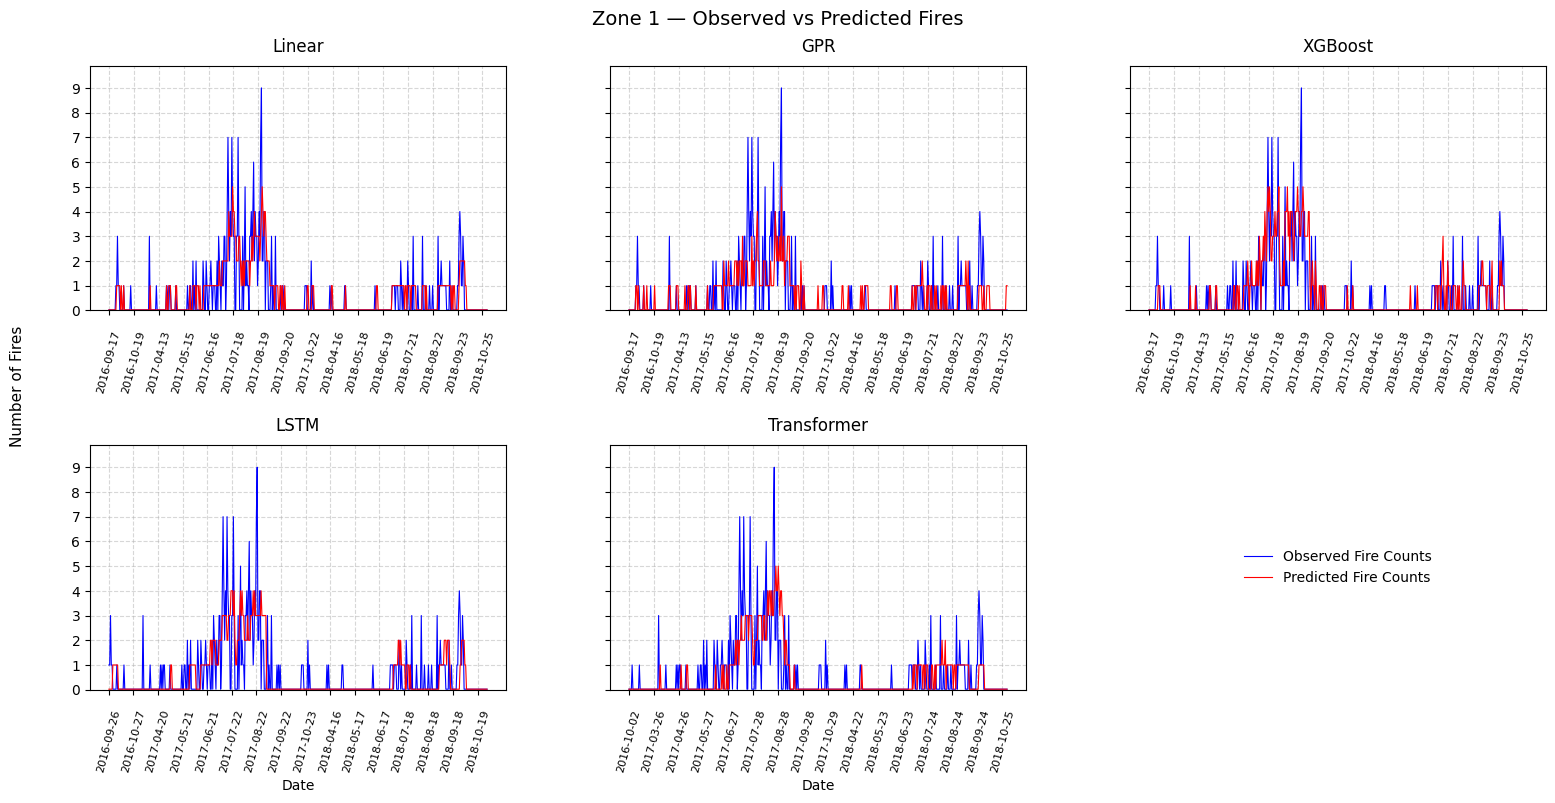

Saved observed vs predicted figure for zone 1 -> /nfshome/samuel/ThesisProject/Model_Training_Evaluation_Selection/result_plots


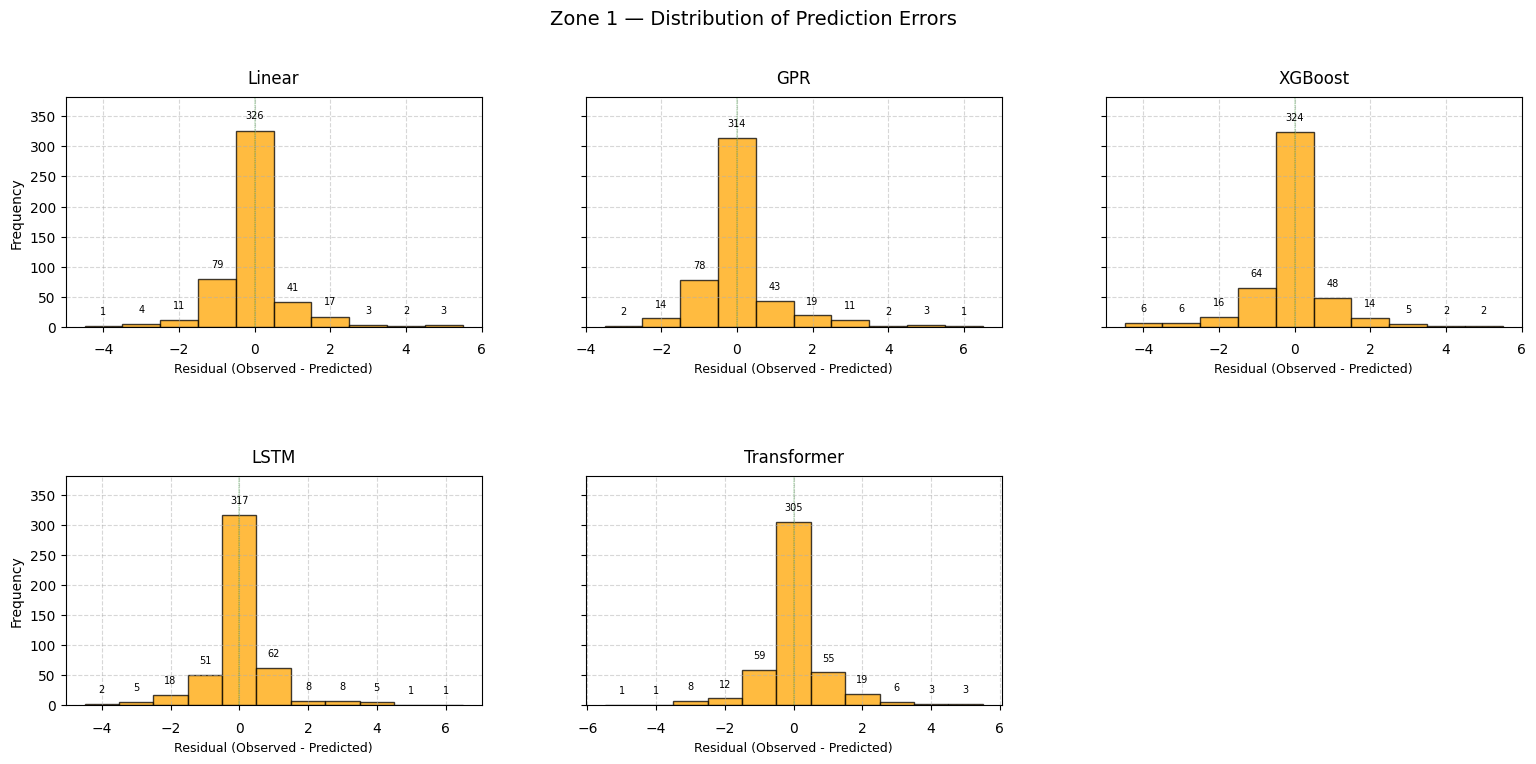

Saved residuals figure for zone 1 -> /nfshome/samuel/ThesisProject/Model_Training_Evaluation_Selection/residual_result_plots

=== Zone 2 ===


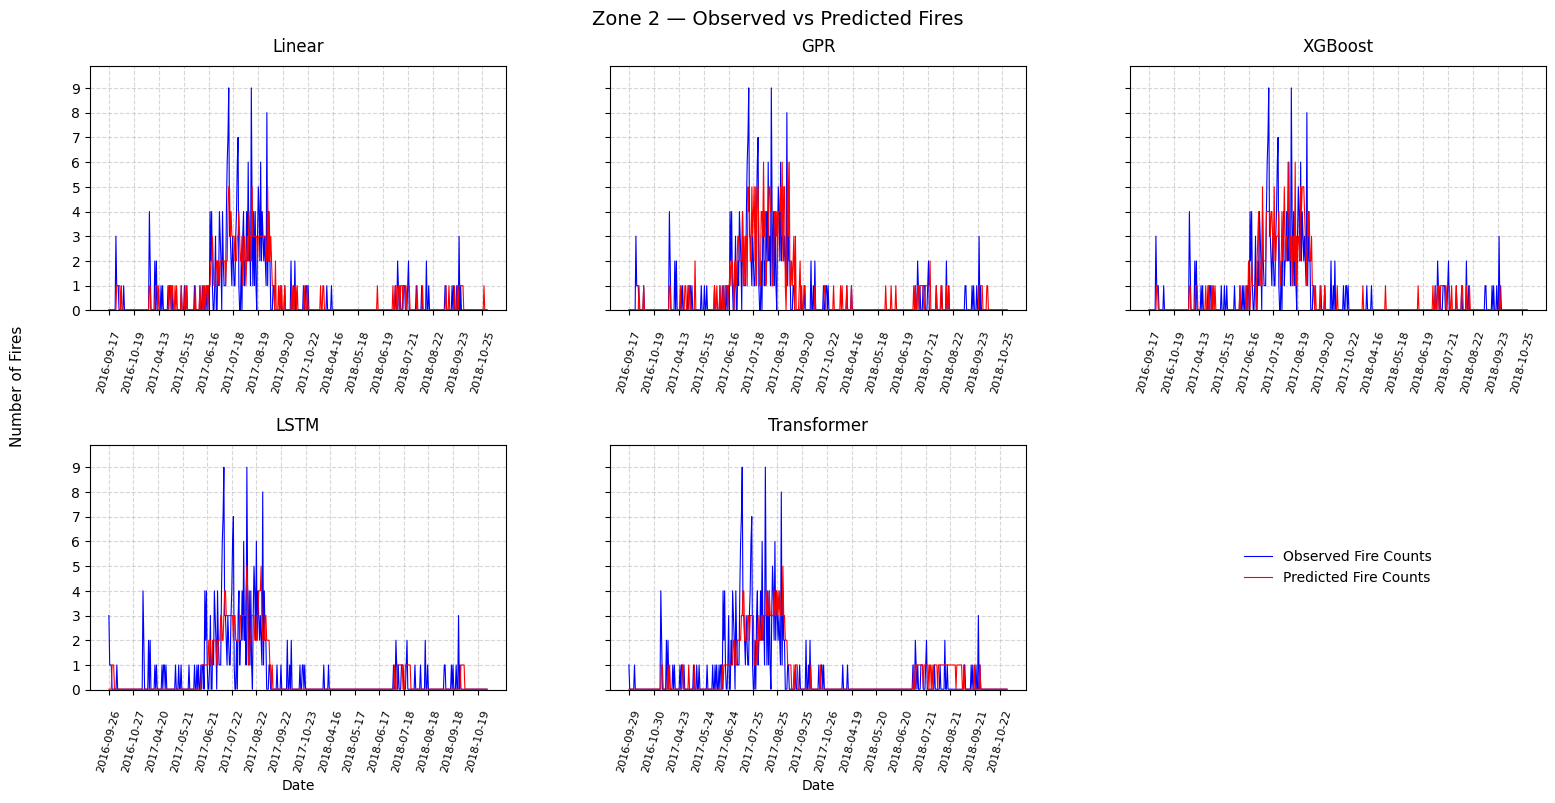

Saved observed vs predicted figure for zone 2 -> /nfshome/samuel/ThesisProject/Model_Training_Evaluation_Selection/result_plots


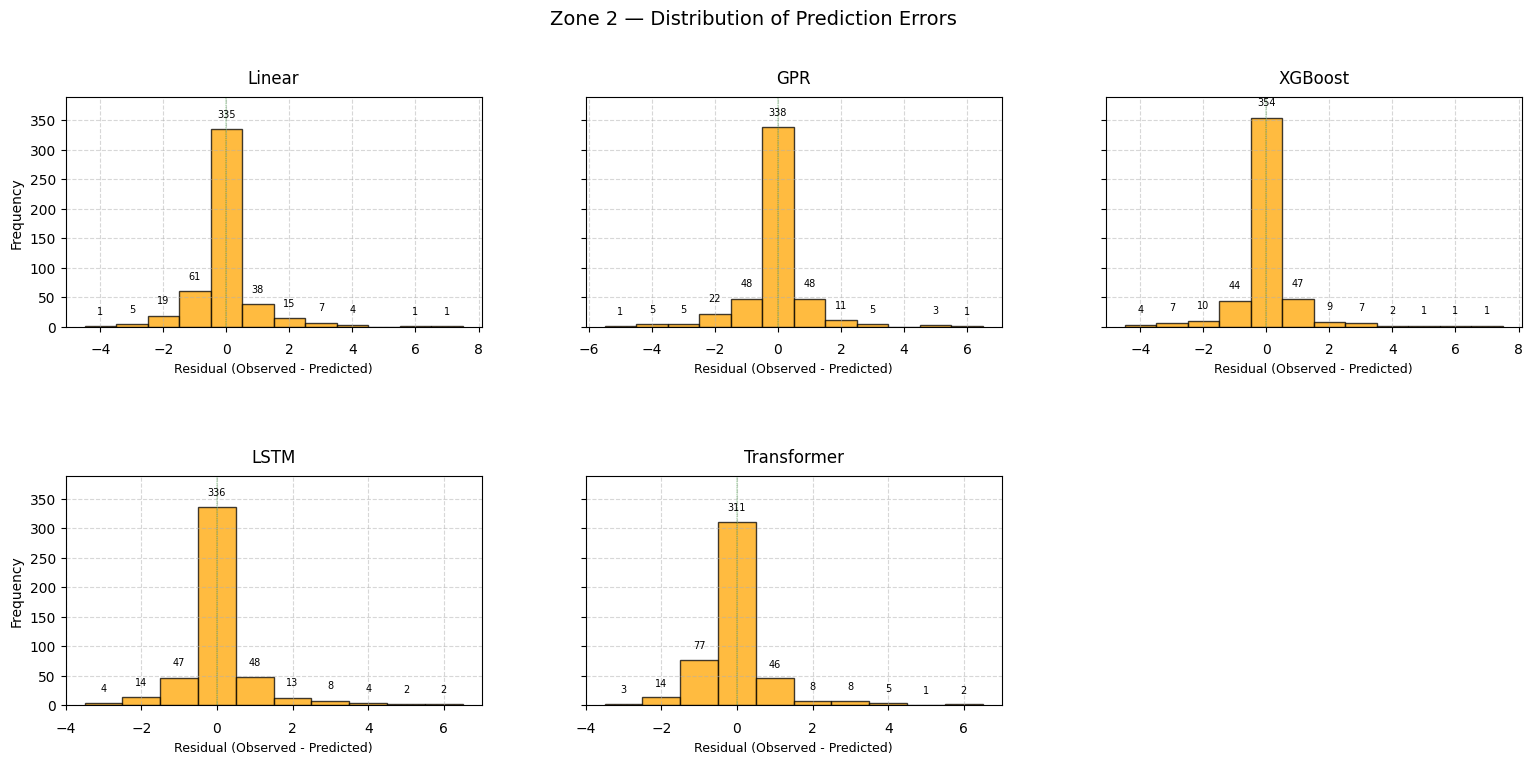

Saved residuals figure for zone 2 -> /nfshome/samuel/ThesisProject/Model_Training_Evaluation_Selection/residual_result_plots

=== Zone 3 ===


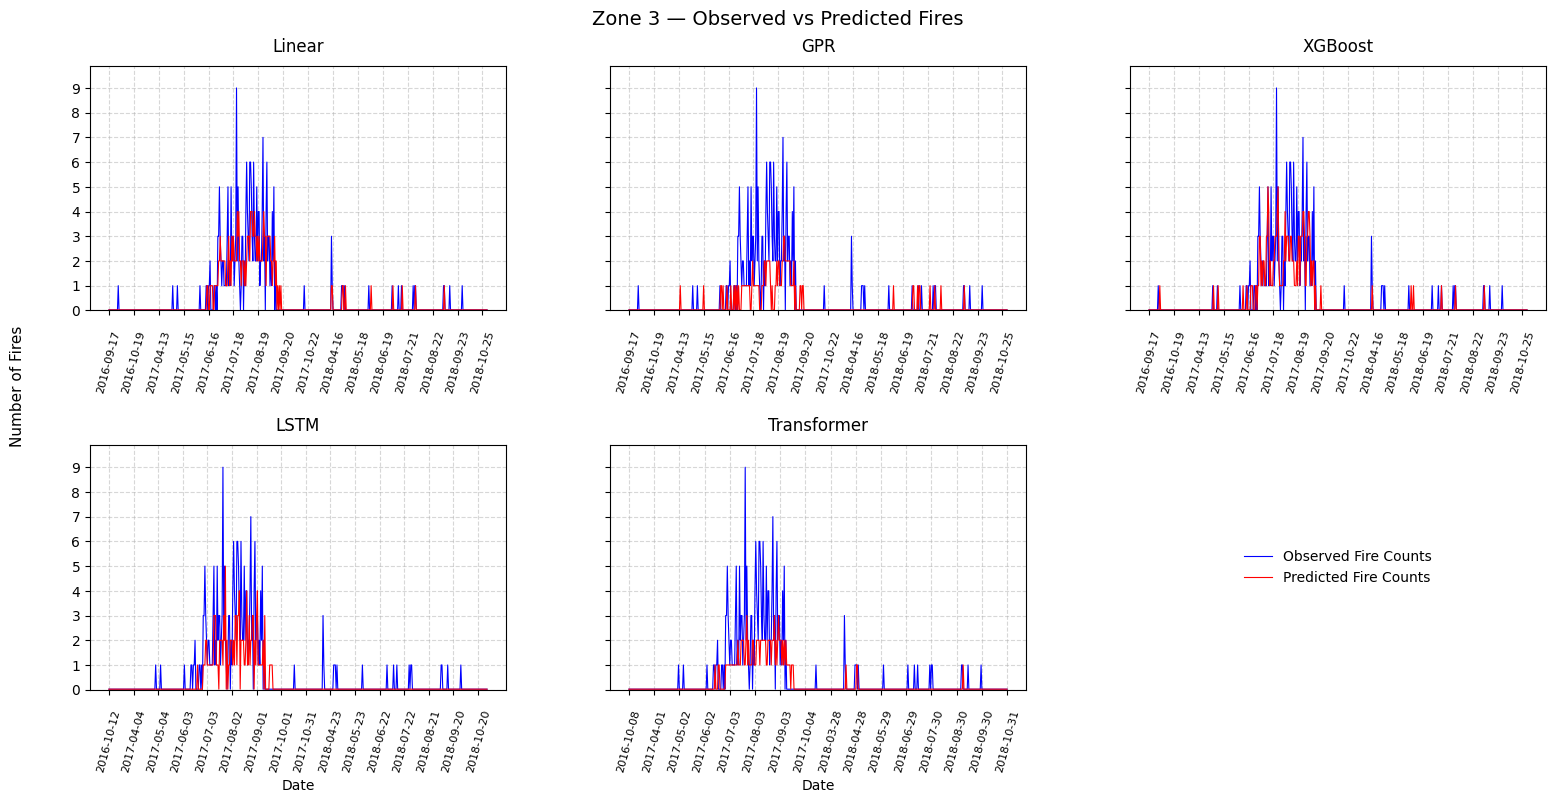

Saved observed vs predicted figure for zone 3 -> /nfshome/samuel/ThesisProject/Model_Training_Evaluation_Selection/result_plots


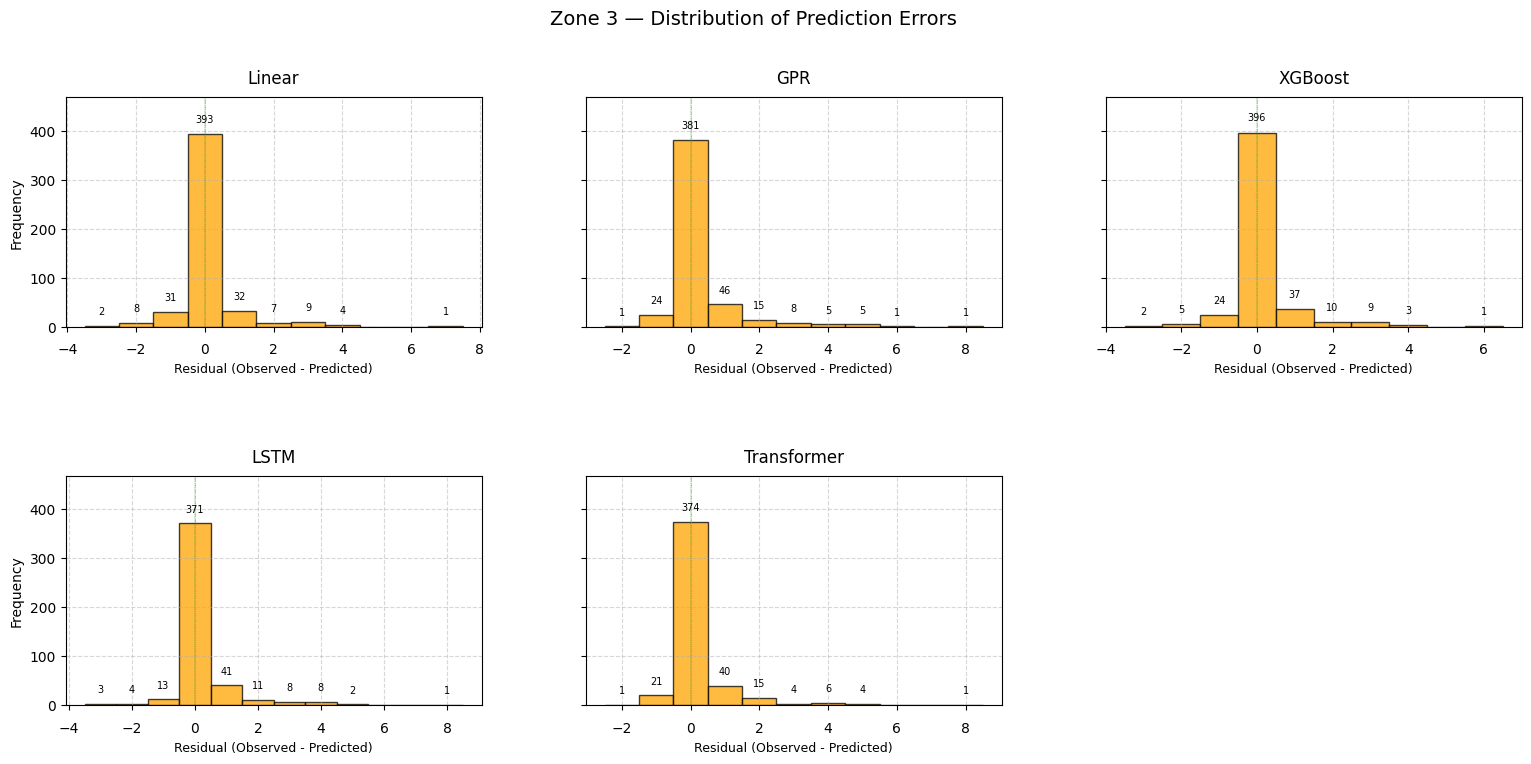

Saved residuals figure for zone 3 -> /nfshome/samuel/ThesisProject/Model_Training_Evaluation_Selection/residual_result_plots

=== Zone 4 ===


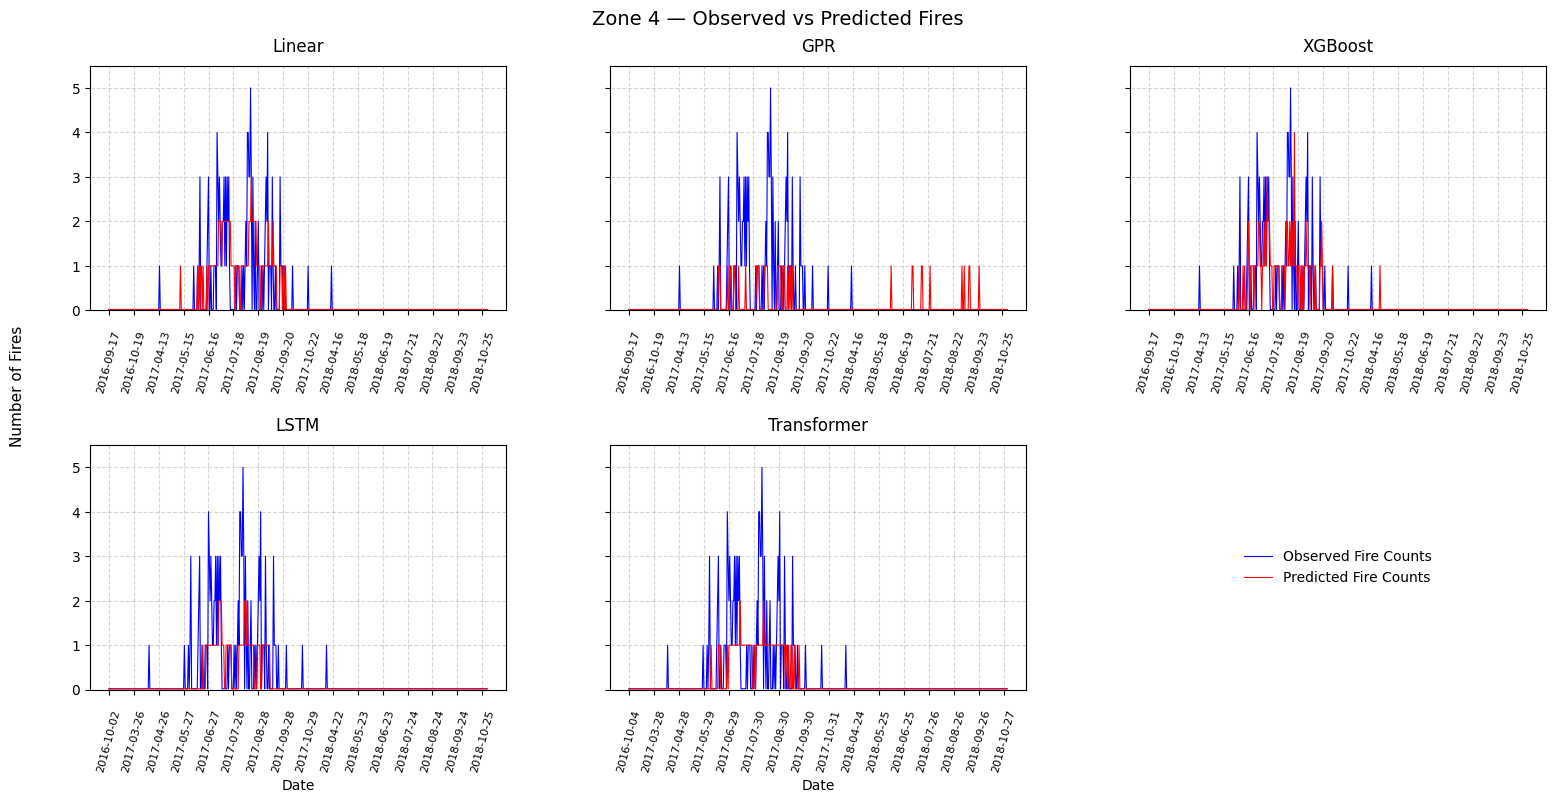

Saved observed vs predicted figure for zone 4 -> /nfshome/samuel/ThesisProject/Model_Training_Evaluation_Selection/result_plots


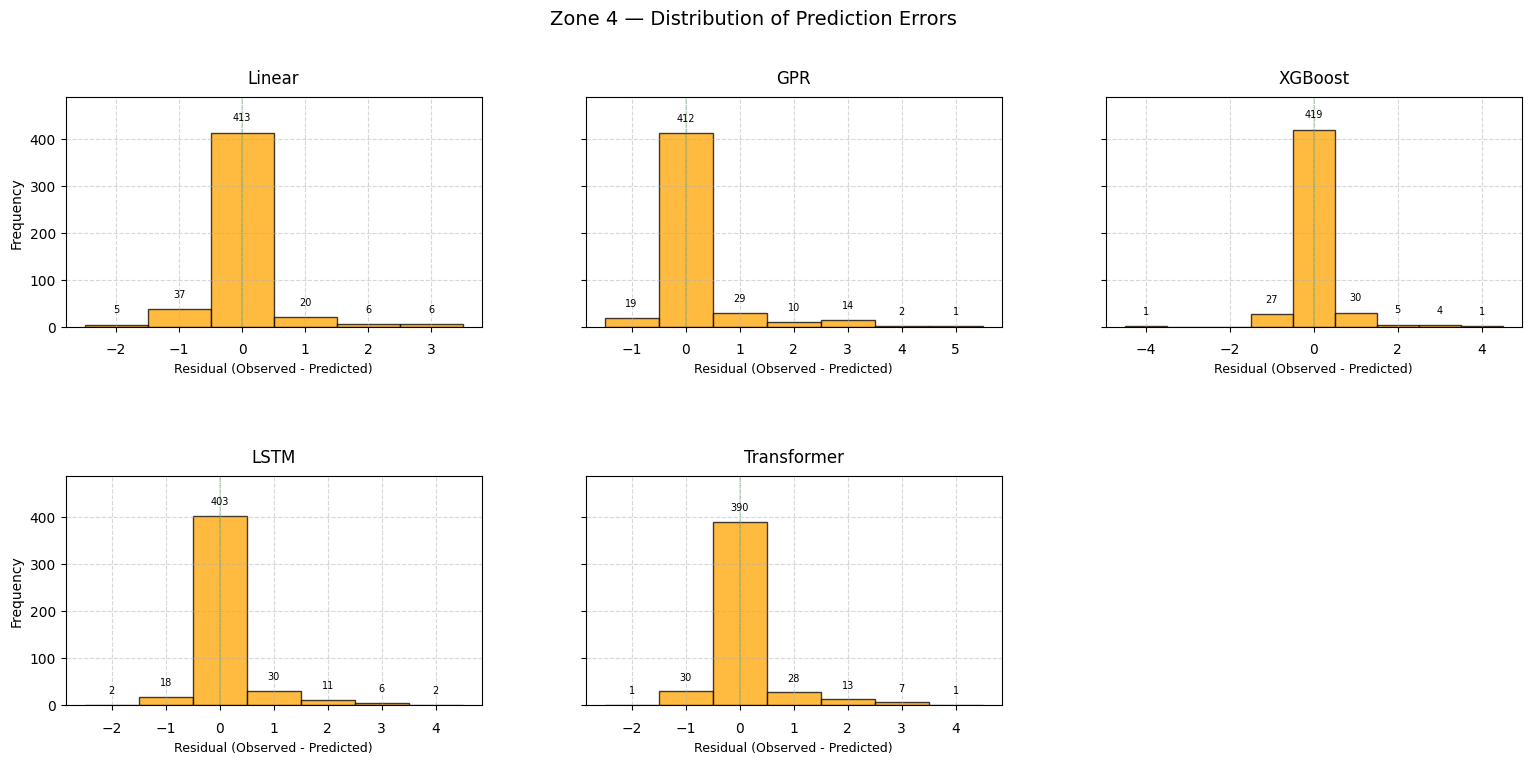

Saved residuals figure for zone 4 -> /nfshome/samuel/ThesisProject/Model_Training_Evaluation_Selection/residual_result_plots

=== Zone 5 ===


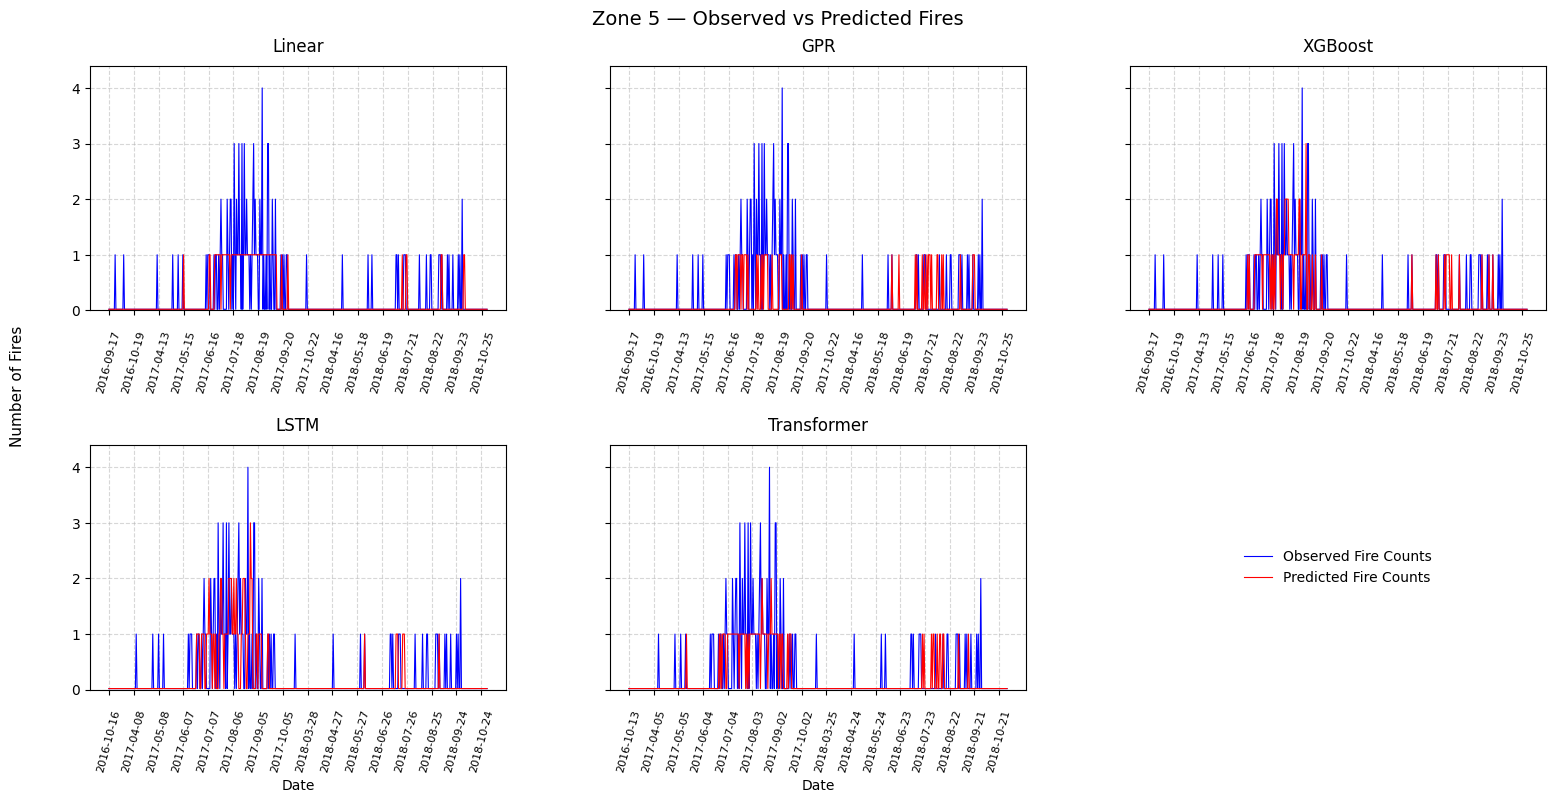

Saved observed vs predicted figure for zone 5 -> /nfshome/samuel/ThesisProject/Model_Training_Evaluation_Selection/result_plots


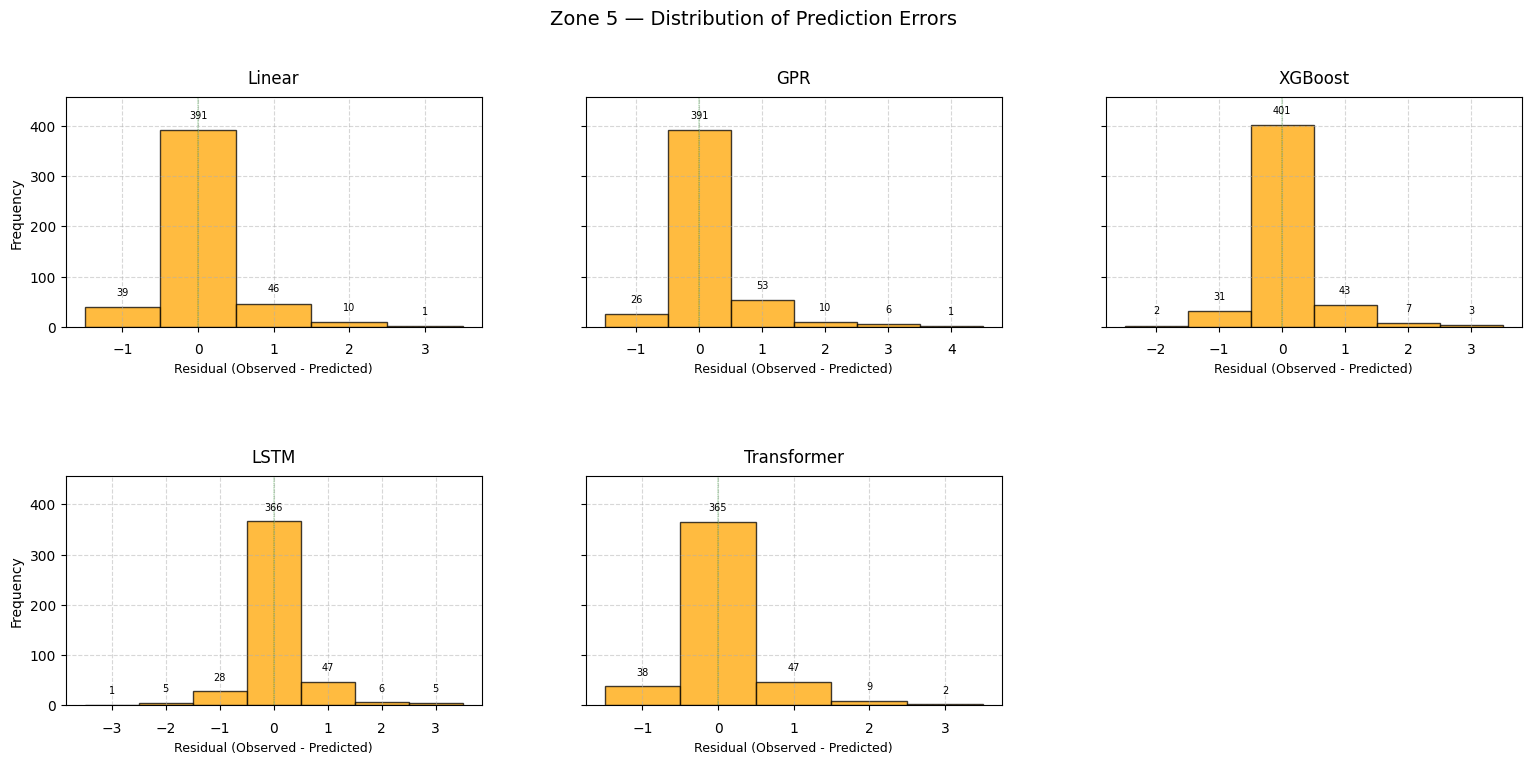

Saved residuals figure for zone 5 -> /nfshome/samuel/ThesisProject/Model_Training_Evaluation_Selection/residual_result_plots

=== Zone 6 ===


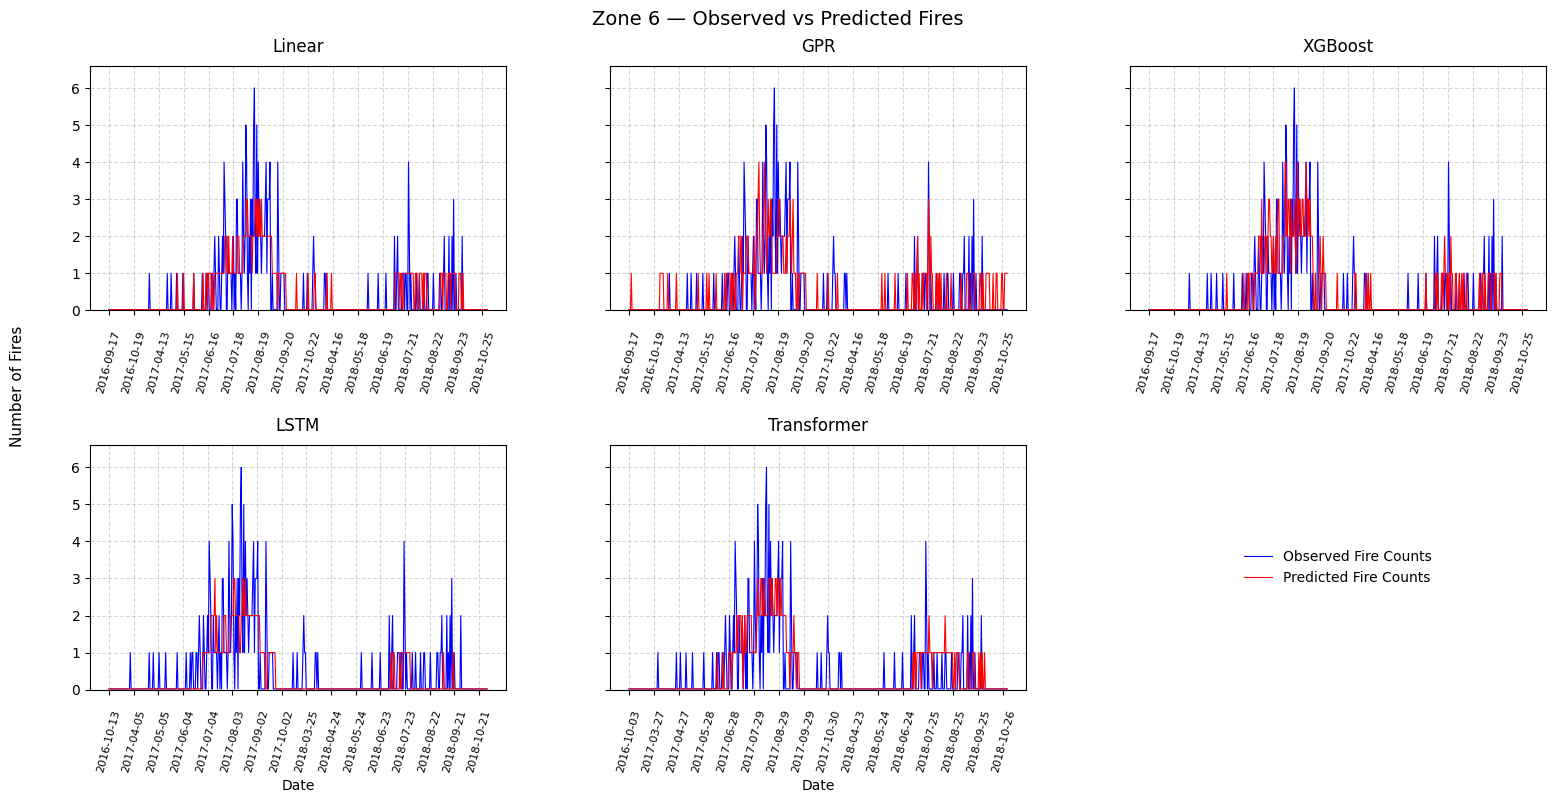

Saved observed vs predicted figure for zone 6 -> /nfshome/samuel/ThesisProject/Model_Training_Evaluation_Selection/result_plots


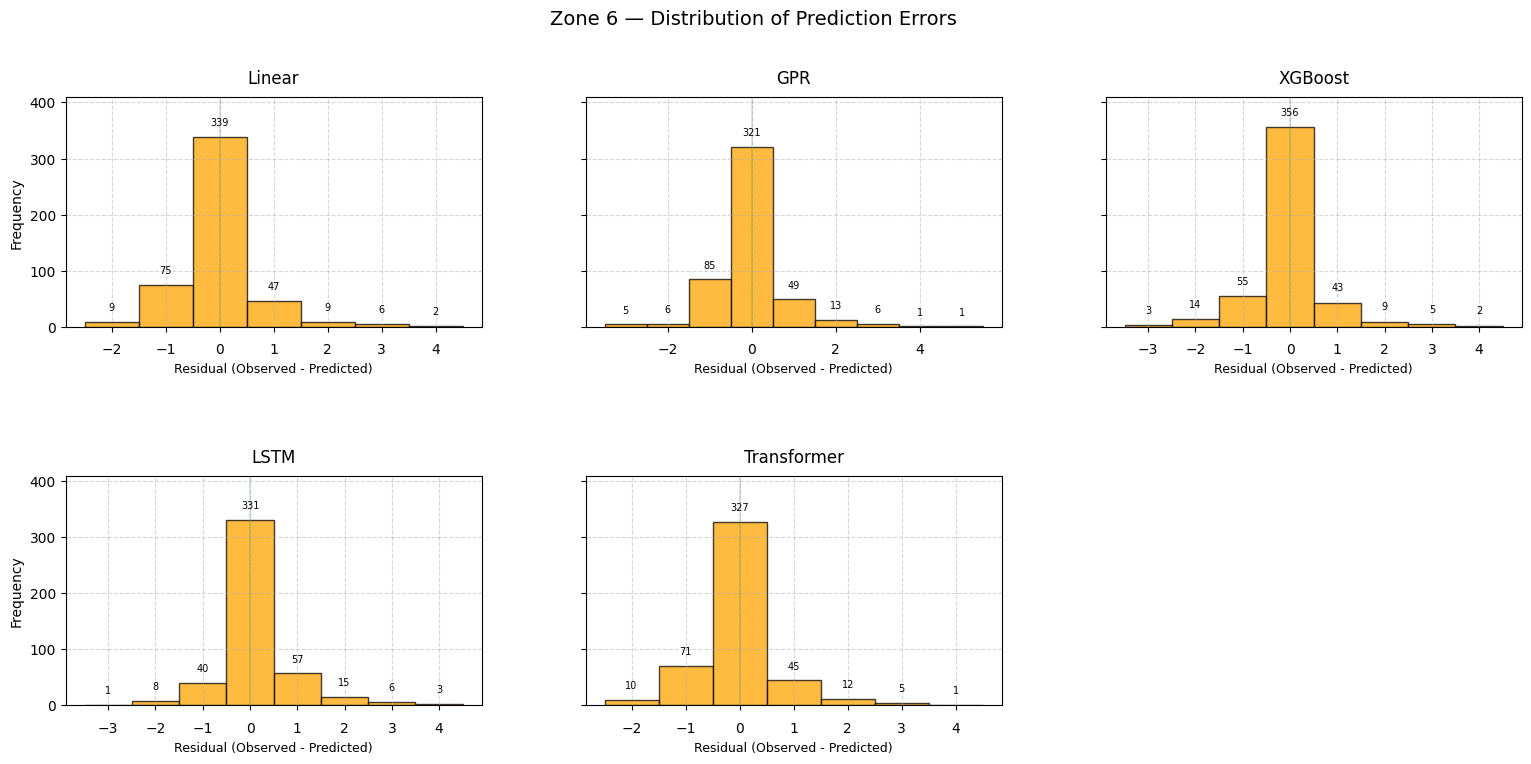

Saved residuals figure for zone 6 -> /nfshome/samuel/ThesisProject/Model_Training_Evaluation_Selection/residual_result_plots

=== Zone 7 ===


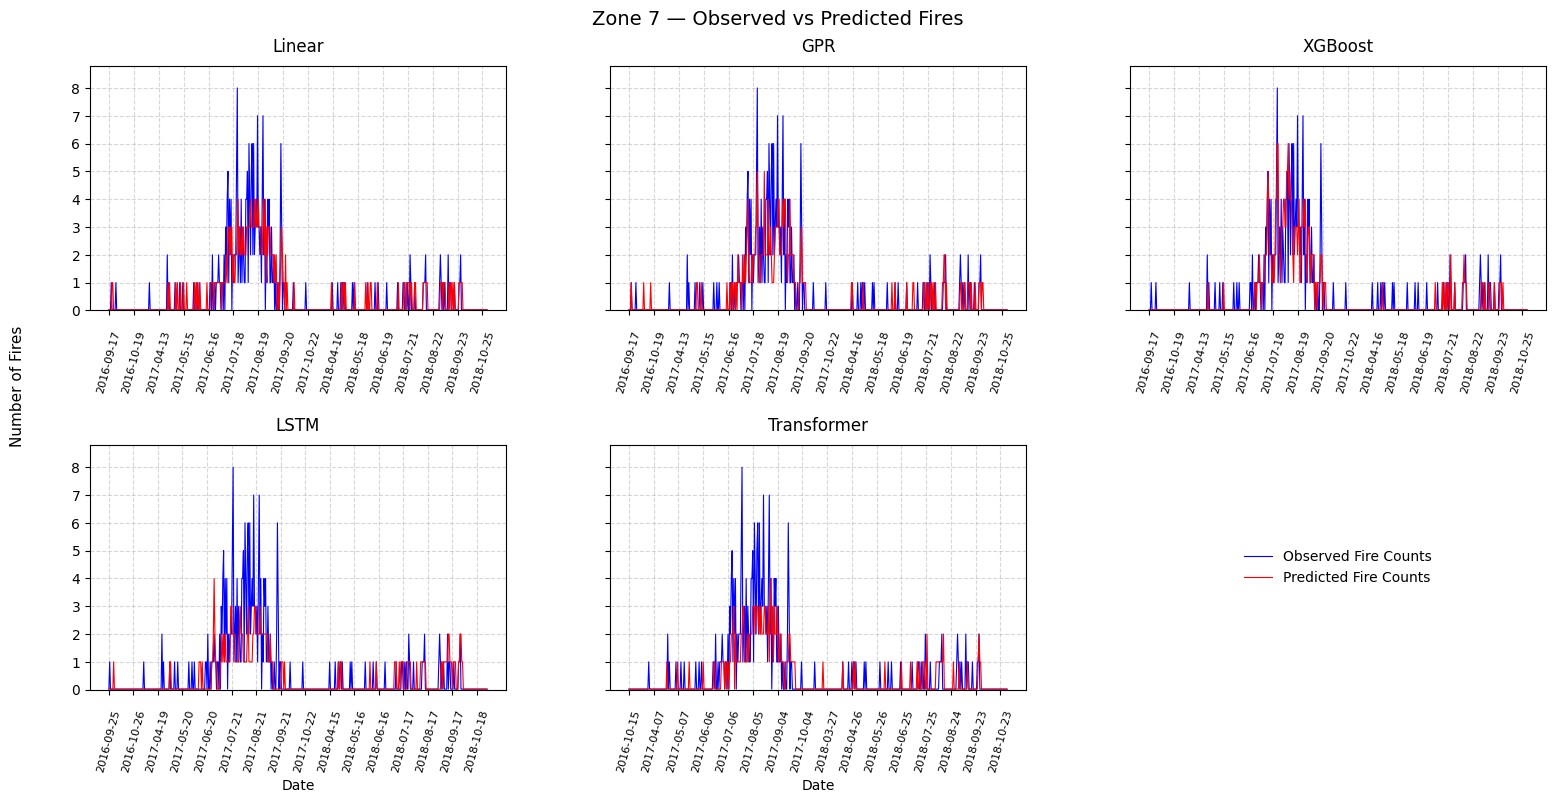

Saved observed vs predicted figure for zone 7 -> /nfshome/samuel/ThesisProject/Model_Training_Evaluation_Selection/result_plots


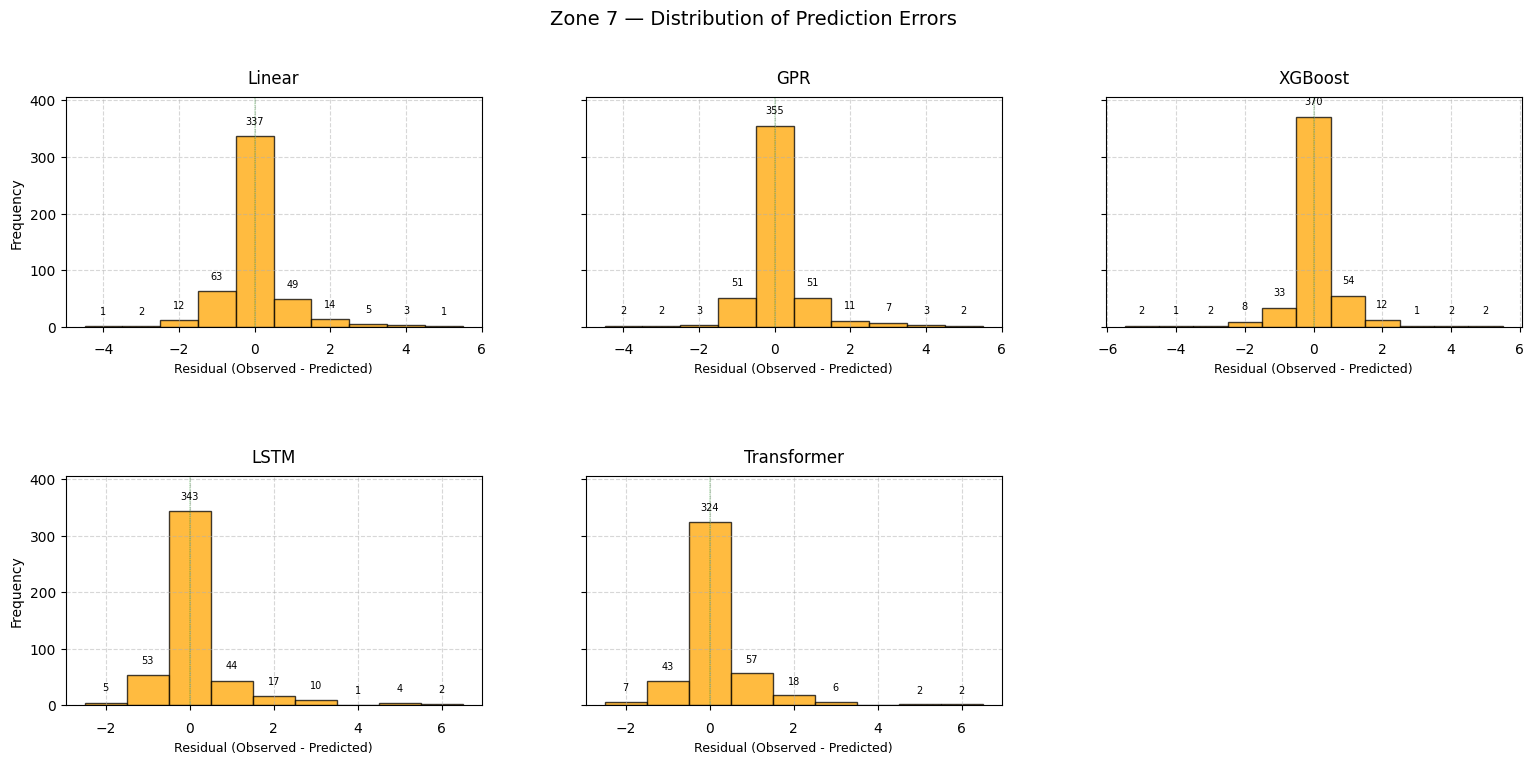

Saved residuals figure for zone 7 -> /nfshome/samuel/ThesisProject/Model_Training_Evaluation_Selection/residual_result_plots

=== Zone 8 ===


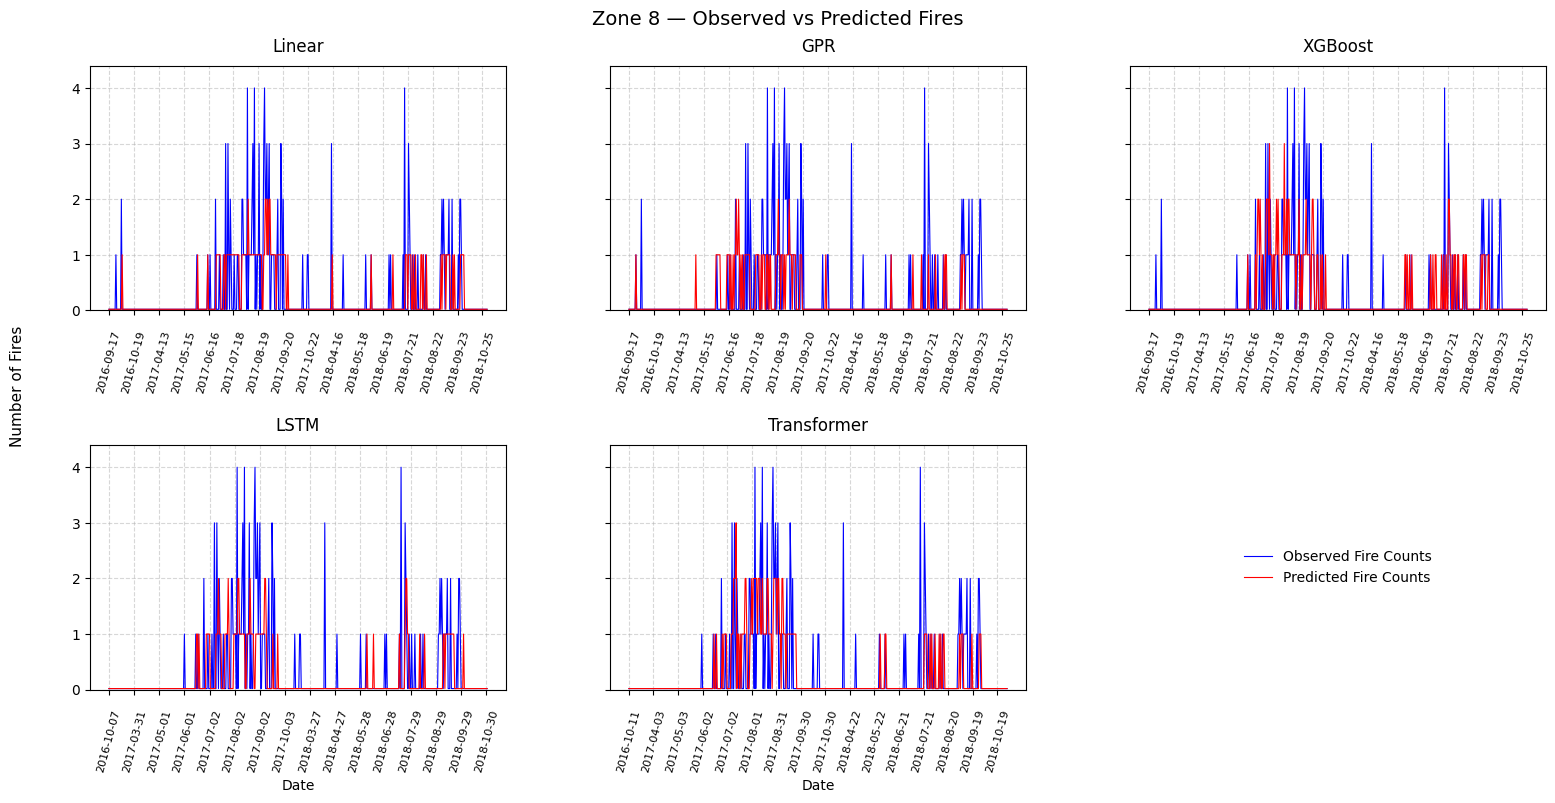

Saved observed vs predicted figure for zone 8 -> /nfshome/samuel/ThesisProject/Model_Training_Evaluation_Selection/result_plots


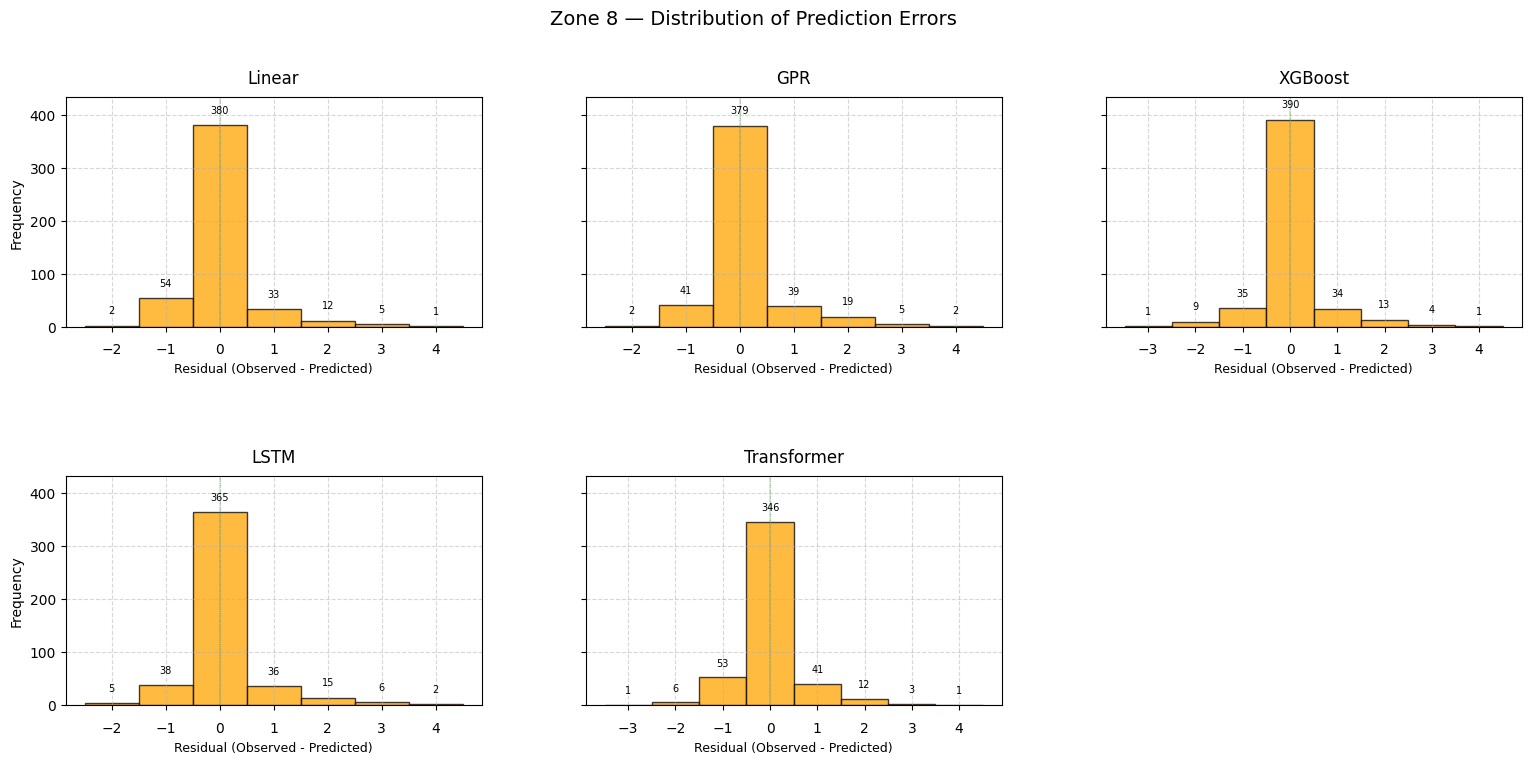

Saved residuals figure for zone 8 -> /nfshome/samuel/ThesisProject/Model_Training_Evaluation_Selection/residual_result_plots

=== Zone regional ===


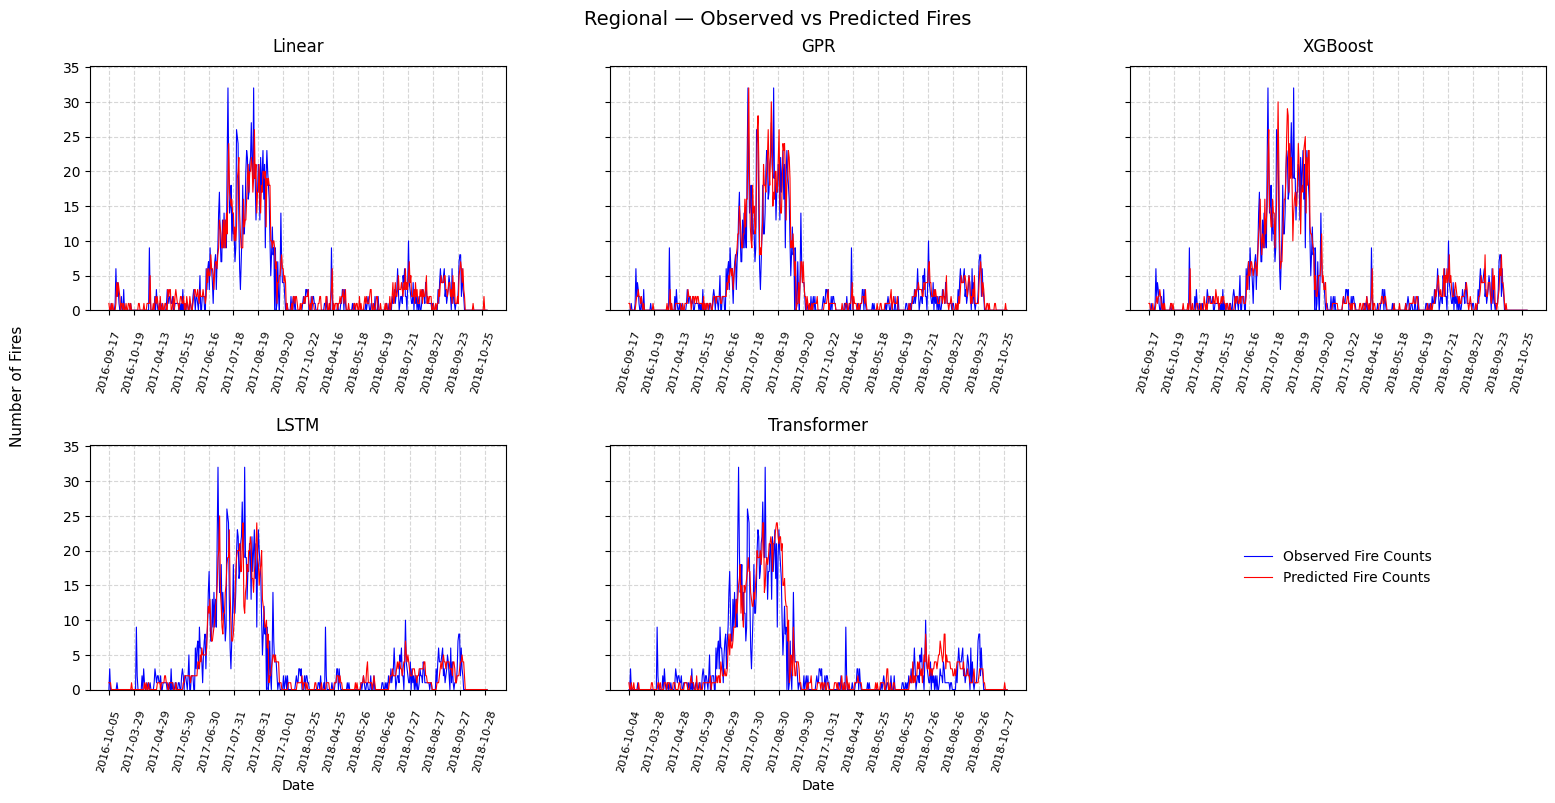

Saved observed vs predicted figure for zone regional -> /nfshome/samuel/ThesisProject/Model_Training_Evaluation_Selection/result_plots


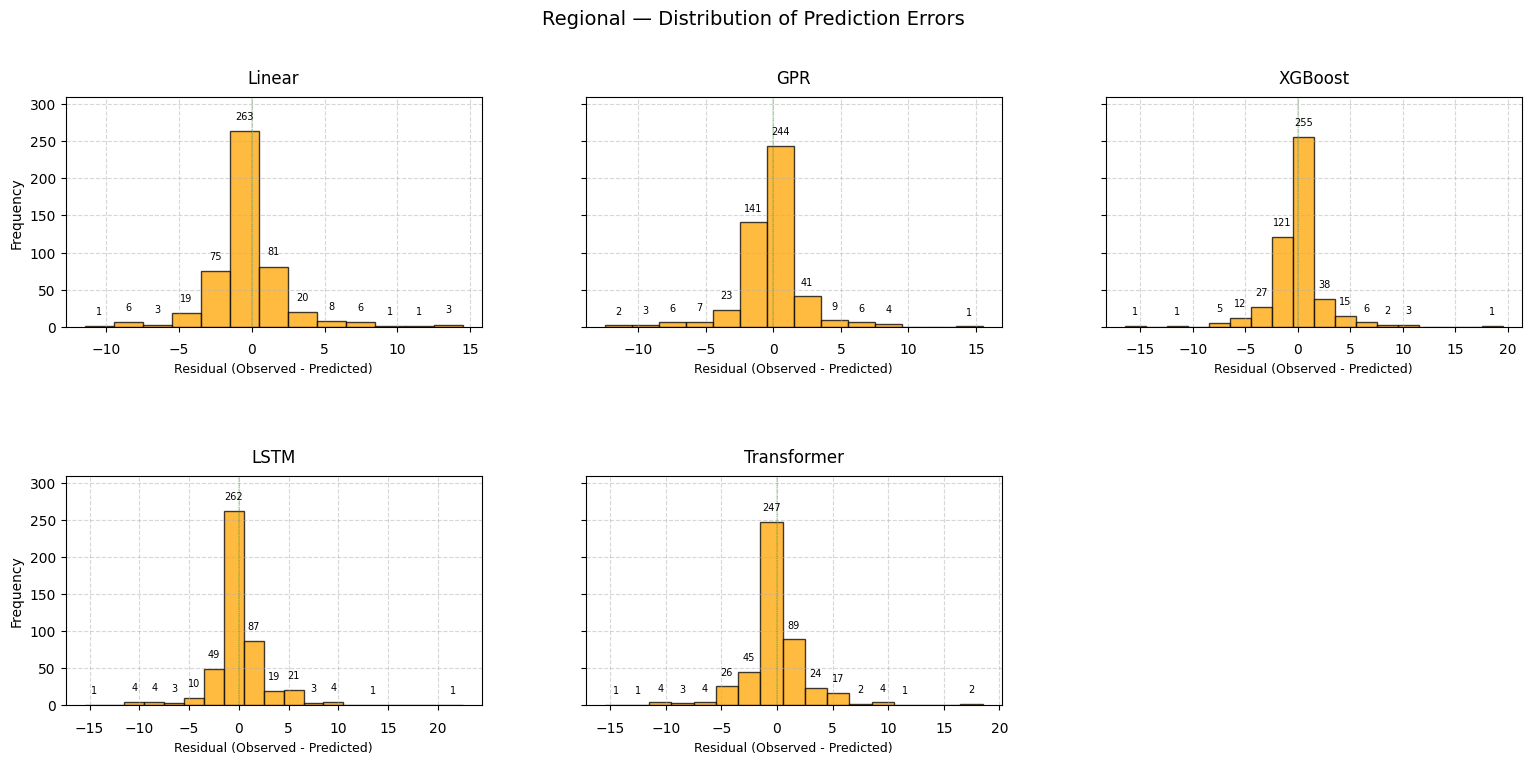

Saved residuals figure for zone regional -> /nfshome/samuel/ThesisProject/Model_Training_Evaluation_Selection/residual_result_plots


In [173]:
ROOT = "/nfshome/samuel/ThesisProject/Model_Training_Evaluation_Selection"
save_dir_pred = os.path.join(ROOT, "result_plots")
save_dir_resid = os.path.join(ROOT, "residual_result_plots")

zone_model_ids = {
    1: [10, 93, 7, 167, 176],
    2: [6, 51, 54, 51, 64],
    3: [13, 50, 95, 53, 178],
    4: [7, 61, 24, 13, 83],
    5: [2, 284, 98, 81, 161],
    6: [5, 31, 18, 45, 232],
    7: [11, 228, 30, 109, 250],
    8: [18, 236, 24, 202, 103],
    "regional": [16, 95, 73, 5, 86],
}

fam_order = ["Linear", "XGBoost", "GPR", "LSTM", "Transformer"]

for zone_id, model_ids in zone_model_ids.items():
    print(f"\n=== Zone {zone_id} ===")

    params_by_family = {}
    for fam, mid in zip(fam_order, model_ids):
        params_by_family[fam] = load_params_for_model(ROOT, fam, zone_id, mid)

    preds = run_zone(zone_id, ROOT, model_ids, params_by_family, save_dir=save_dir_pred)
    print(f"Saved observed vs predicted figure for zone {zone_id} -> {save_dir_pred}")

    save_path_resid = os.path.join(save_dir_resid, f"zone_{zone_id}_residual_subplots.png")
    plot_residuals(zone_id, preds, save_path=save_path_resid)
    print(f"Saved residuals figure for zone {zone_id} -> {save_dir_resid}")
